# BP神经网络
## 利用scikit-learn,实现BPNN的分类和回归，数据集自己选择


In [30]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris # 加载鸢尾花数据集 分类
from sklearn.datasets import load_boston # 波士顿房价数据集 经典回归
from sklearn.neural_network import MLPClassifier # 分类模型
from sklearn.neural_network import MLPRegressor # 回归模型
import numpy as np
iris, boston = load_iris(), load_boston()
iris.keys() # dict_keys(['target', 'DESCR', 'data', 'target_names', 'feature_names'])
boston.keys() # dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])
n_samples,n_features = iris['data'].shape # 同iris.data.shape；150个样本4个特征 3个类别
X, y = iris.data, iris.target
# stratify参数通常用于类别不均匀时
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10,stratify=y) 
# 分类模型 默认max_iter=200
cl_model = MLPClassifier(hidden_layer_sizes=(10,), random_state=10, learning_rate_init=0.1)
cl_model.fit(X_train, y_train) # 训练
pred = cl_model.predict(X_test)
def acc(pred, y):
    return np.sum(pred==y)/y.size
print(f"在{y_test.size}个测试数据上的预测准确率为{acc(pred, y_test)}")
print(pred,y_test,sep='\n')


在30个测试数据上的预测准确率为1.0
[1 0 1 2 1 2 0 2 2 0 0 1 2 2 1 0 0 1 2 0 2 2 2 0 0 1 1 0 1 1]
[1 0 1 2 1 2 0 2 2 0 0 1 2 2 1 0 0 1 2 0 2 2 2 0 0 1 1 0 1 1]


In [31]:
# 统计各个类别出现的次数
from collections import Counter
counter = Counter(iris.target)
print(dict(counter))
iris.target

{0: 50, 1: 50, 2: 50}


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

预测结果的均方根误差8.133853424661128,
预测结果的平均决对误差6.346166984951275


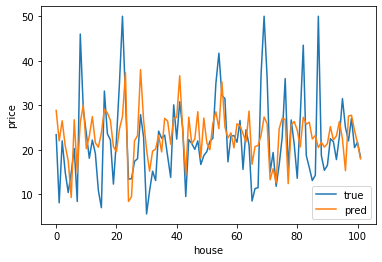

In [58]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error #MSE
from sklearn.metrics import mean_absolute_error # MAE
# 回归模型
X, y = boston.data, boston.target
# 在回归模型中是不能用stratify参数的
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=11) 
re_model = MLPRegressor(hidden_layer_sizes=(50,50), random_state=10, max_iter=1800)
re_model.fit(X_train, y_train)
pred = re_model.predict(X_test)
RMSE = np.sqrt(mean_squared_error(y_test,pred))  # RMSE就是对MSE开方即可
MAE = mean_absolute_error(y_test,pred)
plt.figure('regression')
p1, = plt.plot(y_test)
p2, = plt.plot(pred)
plt.legend(['true','pred'])
plt.ylabel('price')
plt.xlabel('house')
print(f'预测结果的均方根误差{RMSE},\n预测结果的平均决对误差{MAE}')

In [59]:
re_model.n_layers_

4

## 自己编程实现三层前向神经网络的BP算法
不允许调库，利用数据集检验自编BPNN效果，数据集可选分类或回归
### 数据处理
需要进行onehot编码

In [65]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits
from collections import Counter

digits = load_digits()
X,y = iris.data, iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=12)

def num_class(y): # 统计有多少类标签
    counter = Counter(y)
    print(counter)
    return len(counter)

def convert_y_to_vect(y,num_class):
    """将标签转换为独热向量"""
    y_vect = np.zeros((len(y), num_class))
    for i in range(len(y)):
        y_vect[i, y[i]] = 1
    return y_vect

n = num_class(y)
y_v_train = convert_y_to_vect(y_train,n)
y_v_test = convert_y_to_vect(y_test,n)
y_train[0], y_v_train[0]


Counter({0: 50, 1: 50, 2: 50})


(2, array([0., 0., 1.]))

### 初始化模型参数
对于每一层我们都要记录一个权重矩阵和一个偏置向量。要为这些参数的损失的梯度分配内存。
### 定义每一层的损失

In [66]:

def f(x): # 实现sigmoid函数
    return 1 / (1 + np.exp(-x))
def f_deriv(x): # 实现sigmoid函数的导数
    return f(x) * (1 - f(x))

def setup_and_init_weights(nn_structure):
    """随机初始化权重；"""
    W = {}
    b = {}
    for l in range(1, len(nn_structure)): # 大小在0到1之间；32X输入特征数 类别数X32
        W[l] = r.random_sample((nn_structure[l], nn_structure[l-1]))
        b[l] = r.random_sample((nn_structure[l],))
    return W, b

def init_tri_values(nn_structure):
    """初始化w和b同样大小的矩阵 存储梯度或损失"""
    tri_W = {}
    tri_b = {}
    for l in range(1, len(nn_structure)): # 权重初始化， [32,输入特征数] [类别数,32]
        tri_W[l] = np.zeros((nn_structure[l], nn_structure[l-1]))
        tri_b[l] = np.zeros((nn_structure[l],))
    return tri_W, tri_b


def calculate_out_layer_delta(y, h_out, z_out):
    """计算输出层损失Δ 书上公式5.10的倒数第二步

    h_out是最终输出，z_out是激活前的输出
    """
    # delta^(nl) = -(y_i - h_i^(nl)) * f'(z_i^(nl))
    return -(y-h_out) * f_deriv(z_out)

def calculate_hidden_delta(delta_plus_1, w_l, z_l):
    """计算隐藏层损失  """
    # delta^(l) = (transpose(W^(l)) * delta^(l+1)) * f'(z^(l))
    return w_l.T @ delta_plus_1 * f_deriv(z_l)


### BP算法的具体实现
训练时首先前向传播，然后计算梯度，求每一层损失，反向传播更新参数

In [67]:

def feed_forward(x, W, b):
    """前向传播计算每一层输出结果z，以及每一层经过激活后的输出结果h
    返回值为dict，其中h1为原始输入"""
    h = {1: x} # 第一个隐藏层输入为x
    z = {}
    for l in range(1, len(W) + 1):
        if l == 1: # 第一个隐藏层的输入是x
            node_in = x
        else: # 否则输入就是上一个层的输出
            node_in = h[l]
        # 对输入与权重矩阵做乘法并加上偏置
        z[l+1] = W[l].dot(node_in) + b[l] # z^(l+1) = W^(l)*h^(l) + b^(l) 
        # 激活后当前层的输出 
        h[l+1] = f(z[l+1]) # h^(l) = f(z^(l)) 
    return h, z

def train_nn(nn_structure, X, y, iter_num=3000, alpha=0.25):
    W, b = setup_and_init_weights(nn_structure) # 网络权重保存在其中
    cnt = 0
    m = len(y)
    avg_cost_func = [] # 记录每一代的平均损失
    print(f'使用梯度下降对所有样本迭代{iter_num}次')
    while cnt < iter_num:
        tri_W, tri_b = init_tri_values(nn_structure) # 权重和偏置的梯度首先置为0
        avg_cost = 0 # 平均损失
        for i in range(len(y)):
            delta = {}
            # 对每个样本进行前向传播，算出每层的输出h，以及激活前的输出z
            # 用梯度下降算法
            h, z = feed_forward(X[i, :], W, b)
            # 反向传播每个样本的损失，从最后一层开始
            for l in range(len(nn_structure), 0, -1):
                if l == len(nn_structure): # 算每个样本的输出层损失
                    delta[l] = calculate_out_layer_delta(y[i,:], h[l], z[l])
                    avg_cost += np.linalg.norm((y[i,:]-h[l]))
                else: 
                    if l > 1: # 隐藏层损失的计算是根据当前层与下一层连接的权重矩阵以及下一次的损失计算出来的
                        delta[l] = calculate_hidden_delta(delta[l+1], W[l], z[l])
                    # 在所有样本计算完一次之前，累积w和b对x的梯度
                    # triW^(l) = triW^(l) + delta^(l+1) * transpose(h^(l)
                    # 新加一个维度以便进行矩阵乘法
                    tri_W[l] += np.dot(delta[l+1][:,np.newaxis], h[l][:,np.newaxis].T ) 
                    # trib^(l) = trib^(l) + delta^(l+1)
                    tri_b[l] += delta[l+1]
        
        # 当所有样本都完成了正向和反向传播后，更新权重和偏置
        # 从W2开始更新到W1
        for l in range(len(nn_structure) - 1, 0, -1):
            W[l] += -alpha * (1.0/m * tri_W[l])
            b[l] += -alpha * (1.0/m * tri_b[l])
        # 完成平均损失的计算
        avg_cost = 1.0/m * avg_cost
        avg_cost_func.append(avg_cost)
        cnt += 1
    return W, b, avg_cost_func
    

### 训练

使用梯度下降对所有样本迭代3000次


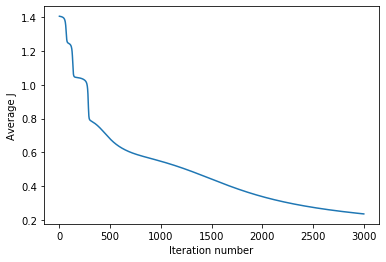

In [68]:
import matplotlib.pyplot as plt
import numpy.random as r
# 输入特征数为4，隐藏神经元个数为30，输出类别为3
nn_structure = [4, 10, 3]
W, b, avg_cost_func = train_nn(nn_structure, X_train, y_v_train)
plt.plot(avg_cost_func)
plt.ylabel('Average J')
plt.xlabel('Iteration number')
plt.show()


### 评价与预测

In [71]:
def predict_y(W, b, X, n_layers):
    m = X.shape[0] # 样本数
    y = np.zeros((m,))
    for i in range(m):
        h, z = feed_forward(X[i, :], W, b)
        y[i] = np.argmax(h[n_layers])
    return y

from sklearn.metrics import accuracy_score
y_pred = predict_y(W, b, X_test, 3)
acc = accuracy_score(y_test, y_pred)*100
acc

98.33333333333333